# Experiment 5: XGBoost / LightGBM (No Mitigation) - Retrain + Validate

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 0: Setup Environment
!pip install xgboost lightgbm shap aif360 scikit-learn pandas matplotlib seaborn joblib openpyxl --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 7.1 MB/s eta 0:00:00


In [3]:
# Step 1: Imports
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [4]:
# Step 2: Load and Preprocess Training Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Use 7 features
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

In [5]:
# Step 3: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

X = aif_data.features
y = aif_data.labels.ravel()

In [6]:
# Step 4: Train XGBoost or LightGBM
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# clf = LGBMClassifier(random_state=42)  # Uncomment to use LightGBM instead

clf.fit(X, y)

# Save model as v2
MODEL_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/xgb_baseline_v2.pkl'
joblib.dump(clf, MODEL_PATH)
print(f'Model retrained and saved to: {MODEL_PATH}')

Model retrained and saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/xgb_baseline_v2.pkl


In [7]:
# Step 5: Preprocess Test Dataset
def preprocess_testdata(df):
    df = df.copy()
    processed = pd.DataFrame()

    # Annual income
    scaler = StandardScaler()
    processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()

    # Term
    le = LabelEncoder()
    processed['term'] = le.fit_transform(df['term'].astype(str))

    # Grade
    le = LabelEncoder()
    processed['grade'] = le.fit_transform(df['grade'].astype(str))

    # Home ownership
    le = LabelEncoder()
    processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

    # Purpose
    le = LabelEncoder()
    processed['purpose'] = le.fit_transform(df['purpose'].astype(str))

    # Protected attribute
    le = LabelEncoder()
    processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))

    # Target
    status_map = {
        'Fully Paid': 1,
        'Current': 1,
        'Charged Off': 0,
        'Default': 0,
        'Late (31-120 days)': 0,
        'Late (16-30 days)': 0,
        'In Grace Period': 0
    }
    df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
    processed['loan_status'] = df['loan_status_mapped']

    return processed.dropna()

In [8]:
# Step 6: Validation Function
def validate_on_testdata(df_processed, model):
    privileged_groups = [{'zip_code': 1}]
    unprivileged_groups = [{'zip_code': 0}]

    aif_data = StandardDataset(df_processed,
                               label_name='loan_status',
                               favorable_classes=[1],
                               protected_attribute_names=['zip_code'],
                               privileged_classes=[[1]])
    X = aif_data.features
    y = aif_data.labels.ravel()
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print('\nPERFORMANCE METRICS')
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print("AUC-ROC:", roc_auc_score(y, y_prob))

    print('\nClassification Report:')
    print(classification_report(y, y_pred, zero_division=0))

    print('\nFAIRNESS METRICS')
    pred_dataset = aif_data.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)
    metric = ClassificationMetric(aif_data, pred_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    print("Statistical Parity Difference:", metric.statistical_parity_difference())
    print("Disparate Impact:", metric.disparate_impact())
    print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
    print("Average Odds Difference:", metric.average_odds_difference())
    print("Bias Amplification:", metric.between_group_generalized_entropy_index())
    print("Theil Index:", metric.theil_index())

    print('\nEXPLAINABILITY METRICS')
    X_df = pd.DataFrame(X, columns=aif_data.feature_names)
    explainer = shap.Explainer(model, X_df)
    shap_values = explainer(X_df)

    # Global plot
    shap.summary_plot(shap_values, X_df, show=False)
    plt.title('SHAP Summary - Experiment 5 (XGBoost Baseline)')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/shap_exp5_testdata.png', dpi=150)
    plt.show()

    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'AUC': roc_auc_score(y, y_prob),
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'BiasAmp': metric.between_group_generalized_entropy_index(),
        'Theil': metric.theil_index()
    }



PERFORMANCE METRICS
Accuracy: 0.7204559088182364
Precision: 0.8360242179616549
Recall: 0.8158542589857213
F1 Score: 0.8258160976825317
AUC-ROC: 0.6201580507459197

Classification Report:
              precision    recall  f1-score   support

         0.0       0.28      0.31      0.29       939
         1.0       0.84      0.82      0.83      4062

    accuracy                           0.72      5001
   macro avg       0.56      0.56      0.56      5001
weighted avg       0.73      0.72      0.73      5001


FAIRNESS METRICS
Statistical Parity Difference: -0.125
Disparate Impact: 0.875
Equal Opportunity Difference: nan
Average Odds Difference: nan
Bias Amplification: 291.3972107438017
Theil Index: 0.20357429991409698

EXPLAINABILITY METRICS


 99%|===================| 4954/5001 [00:20<00:00]       

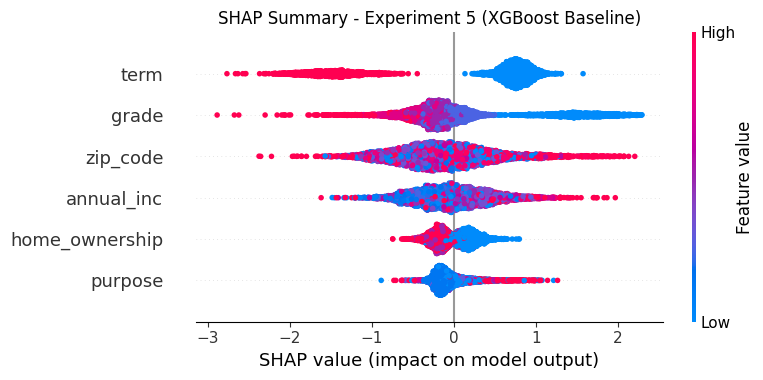

In [9]:
# Step 7: Run Validation
RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results'
TESTDATA_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx'

test_df = pd.read_excel(TESTDATA_PATH)
test_processed = preprocess_testdata(test_df)
results = validate_on_testdata(test_processed, clf)

In [10]:

# Step 8: Save Results
results_df = pd.DataFrame([results])
output_path = f'{RESULTS_DIR}/experiment5_validation_results_testdata.csv'
results_df.to_csv(output_path, index=False)
print(f'\nResults saved to: {output_path}')


Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment5_validation_results_testdata.csv
